In [48]:
import pennylane as qml
import numpy as np

### Single solution phase flip

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

(<Figure size 500x500 with 1 Axes>, <Axes: >)

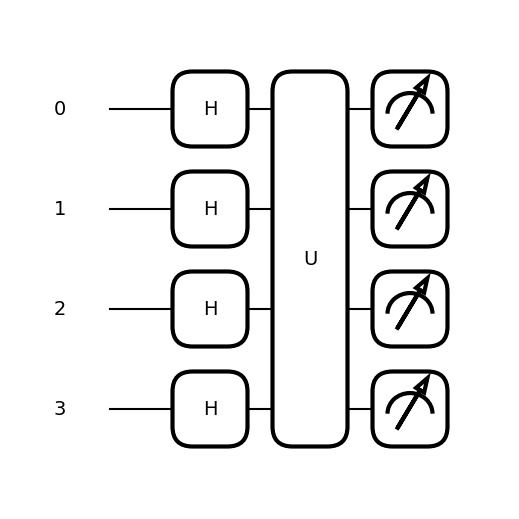

In [49]:
def oracle_matrix(combo):
    index = np.ravel_multi_index(combo, [2]*len(combo)) # Index of solution
    my_array = np.identity(2**len(combo)) # Create the identity matrix

    zero = np.array([[1,0]]).transpose()
    one = np.array([[0,1]]).transpose()
    state_matrix = one if combo[0] == 1 else zero

    for i in combo[1:]:
        if i:
            state_matrix = np.kron(one, state_matrix)
        else:
            state_matrix = np.kron(zero, state_matrix)

    my_array -= 2*np.kron(state_matrix, state_matrix.T)

    return my_array

oracle_matrix([1,1])

n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def oracle_circuit(combo):
    for i in range(n_bits):
        qml.Hadamard(i)

    print (oracle_matrix(combo))
    
    qml.QubitUnitary(oracle_matrix(combo), wires=list(range(n_bits)))
    return qml.state()
    return qml.probs(wires=range(n_bits))

print (qml.QNode(oracle_circuit, dev)([1,0,0,0]))
qml.draw_mpl(oracle_circuit)([1,0,0,0])


[0. 1.]


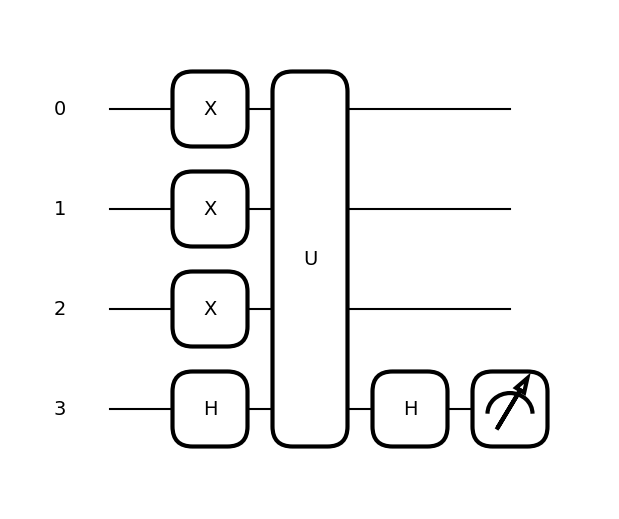

In [50]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def pair_circuit(x_tilde, combo):
    for i in range(n_bits-1): # Initialize x_tilde part of state
        if x_tilde[i] == 1:
            qml.PauliX(wires=i)

    qml.Hadamard(n_bits-1)
    qml.QubitUnitary(oracle_matrix(combo), wires=list(range(n_bits)))
    qml.Hadamard(n_bits-1)

    return qml.probs(wires=n_bits-1)

qml.draw_mpl(pair_circuit)([1,1,1], [1,1,1,1])
print(qml.QNode(pair_circuit, dev)([1,1,1], [1,1,1,1]))

In [51]:
def pair_lock_picker(trials):
    x_tilde_strs = [np.binary_repr(n, n_bits-1) for n in range(2**(n_bits-1))]
    x_tildes = [[int(s) for s in x_tilde_str] for x_tilde_str in x_tilde_strs] 

    test_numbers = []

    secret_combo = lambda n_bits: np.random.choice([0,1], n_bits)

    for trial in range(trials):
        combo = secret_combo(n_bits) # Random list of bits
        counter = 0
        for x_tilde in x_tildes:
            counter += 1
            a = pair_circuit(x_tilde, combo)
            if np.all(np.isclose(a, np.array([0.0,1.0]))):
                break

        test_numbers.append(counter)
    return sum(test_numbers)/trials

trials = 5
output = pair_lock_picker(trials)

print(f"For {n_bits} bits, it takes", output, "pair tests on average.")


For 4 bits, it takes 3.0 pair tests on average.


### Multi solution phase flip

[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]
[0.25 0.25 0.25 0.25]


(<Figure size 500x300 with 1 Axes>, <Axes: >)

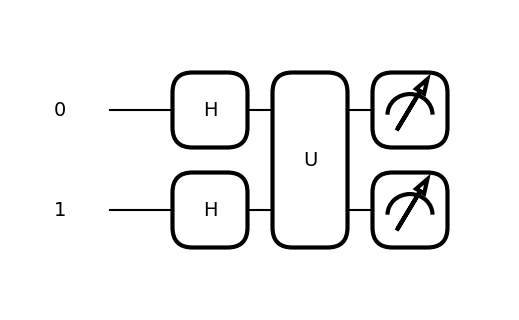

In [52]:
def oracle_matrix(combos):
    indices = [np.ravel_multi_index(combo, [2]*len(combo)) for combo in combos]
    my_array = np.identity(2**len(combos[0])) # Create the identity matrix

    zero = np.array([[1,0]]).transpose()
    one = np.array([[0,1]]).transpose()
    state_matrix = one if combos[0][0] == 1 else zero

    for i in combos[0][1:]:
        if i:
            state_matrix = np.kron(one, state_matrix)
        else:
            state_matrix = np.kron(zero, state_matrix)

    state_matrix_11 = one if combos[1][0] == 1 else zero

    for i in combos[1][1:]:
        if i:
            state_matrix_11 = np.kron(one, state_matrix_11)
        else:
            state_matrix_11 = np.kron(zero, state_matrix_11)

    my_array = my_array - 2*np.kron(state_matrix, state_matrix.T) - 2*np.kron(state_matrix_11, state_matrix_11.T)

    return my_array

print(oracle_matrix([[1,0], [1,1]]))

n_bits = 2
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def oracle_circuit(combos):
    for i in range(n_bits):
        qml.Hadamard(i)
    
    qml.QubitUnitary(oracle_matrix(combos), wires=list(range(n_bits)))
    return qml.probs(wires=range(n_bits))

print (qml.QNode(oracle_circuit, dev)([[1,0], [1,1]]))
qml.draw_mpl(oracle_circuit)([[1,0], [1,1]])


In [53]:
n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

def multisol_oracle_matrix(combos):
    indices = [np.ravel_multi_index(combo, [2]*len(combo)) for combo in combos]
    my_array = np.identity(2**len(combos[0])) # Create the identity matrix
    
    for i in indices:
        my_array[i][i] = -1
    return my_array

@qml.qnode(dev)
def multisol_pair_circuit(x_tilde, combos):
    for i in range(n_bits-1): 
        if x_tilde[i] == 1:
            qml.PauliX(wires=i)
            
    qml.Hadamard(n_bits-1)
    qml.QubitUnitary(multisol_oracle_matrix(combos), wires=list(range(n_bits)))
    qml.Hadamard(n_bits-1)
    
    return qml.probs(wires=n_bits-1)

qml.QNode(multisol_pair_circuit, dev)([1,0,1],[[0,0,0,1]])


tensor([1., 0.], requires_grad=True)

### Deutsz josza algoritm - find if the function is constant or balanced.

(<Figure size 600x500 with 1 Axes>, <Axes: >)

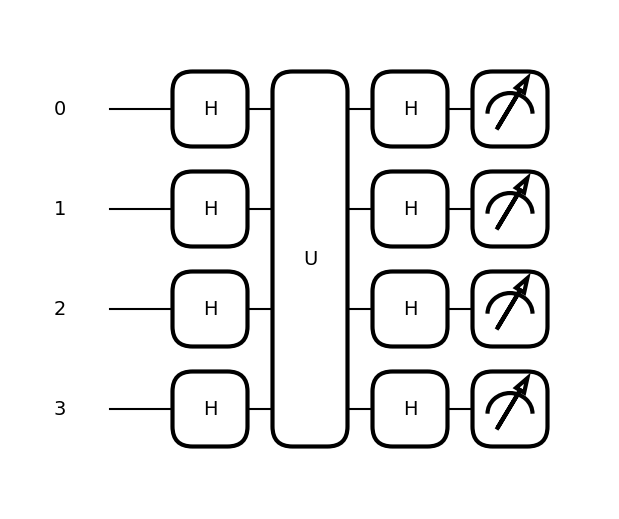

In [54]:
import matplotlib.pyplot as plt 

n_bits = 4
dev = qml.device("default.qubit", wires=n_bits)

@qml.qnode(dev)
def multisol_hoh_circuit(combos):
    for i in range(n_bits):
        qml.Hadamard(i)
    
    qml.QubitUnitary(multisol_oracle_matrix(combos), wires=list(range(n_bits)))
    
    for i in range(n_bits):
        qml.Hadamard(i)
            
    return qml.probs(wires=range(n_bits))

qml.draw_mpl(multisol_hoh_circuit)([[0,0,0,0]])



balanced
constant


(<Figure size 600x500 with 1 Axes>, <Axes: >)

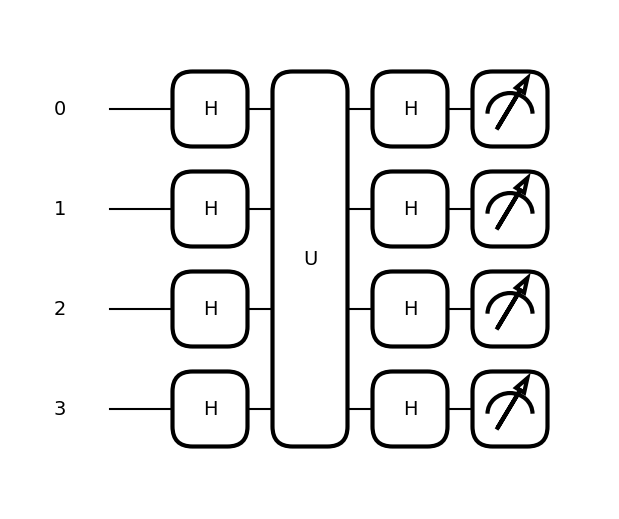

In [56]:
n_bits = 4 
def deutsch_jozsa(promise_var):
    if promise_var == 0:
        combos = [[0, 0, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0], [0, 0, 1, 1], [0, 1, 0, 0], [0, 1, 0, 1], [0, 1, 1, 0], [0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 1], [1, 0, 1, 0], [1, 0, 1, 1], [1, 1, 0, 0], [1, 1, 0, 1], [1, 1, 1, 0], [1, 1, 1, 1]]
    else:
        how_many = np.random.choice([0, 2**n_bits]) # Choose all or nothing randomly
        combos = [[0, 0, 0, 1] for _ in range(how_many)] # + [[0, 0, 0, 1] for _ in range(how_many//2)]

    i = multisol_hoh_circuit(combos)
    print ("balanced" if np.isclose([i[0]], [1.0]) else "constant")

deutsch_jozsa(0)
deutsch_jozsa(1)

qml.draw_mpl(multisol_hoh_circuit)([[0, 0, 0, 1] for _ in range(2**n_bits)])
